In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    FunctionTransformer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


In [2]:
%matplotlib inline

In [3]:
#veri ön analizi
class OnAnaliz(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # İlk 20 satırı göster
        print("İlk 20 Satır:")
        print(X.head(20))
        
        # Bilgileri göster
        print("\nVeri Seti Bilgileri:")
        print(X.info())
        
        # Tanımlayıcı istatistikleri göster
        print("\nTanımlayıcı İstatistikler:")
        print(X.describe(include='all'))
        
        # Eksik değerlerin sayısını göster
        missing_values = X.isnull().sum()
        print("\nEksik Değerler:")
        print(missing_values[missing_values > 0])
        
        return X

#sütun silme
class DropSutunlar(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_drop, axis=1)

#eksik sütunları doldurma
class EksikDegerleriDoldur(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fill, fill_value='Yok'):
        self.columns_to_fill = columns_to_fill
        self.fill_value = fill_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.columns_to_fill] = X[self.columns_to_fill].fillna(self.fill_value)
        return X

#yaş değişkeni hesaplama
class YasHesapla(BaseEstimator, TransformerMixin):
    def __init__(self, date_column='Dogum_Tarihi'):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Yas'] = X[self.date_column].apply(lambda x: datetime.now().year - x.year)
        return X

#tarih bileşenlerini yıl ay gün formatında ayırma
class TarihBilesenleriniAyir(BaseEstimator, TransformerMixin):
    def __init__(self, tarih_sutunlari):
        self.tarih_sutunlari = tarih_sutunlari

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for sutun in self.tarih_sutunlari:
            if sutun in X.columns:
                X[sutun] = pd.to_datetime(X[sutun], errors='coerce')
                X[f'{sutun}_gün'] = X[sutun].dt.day
                X[f'{sutun}_ay'] = X[sutun].dt.month
                X[f'{sutun}_yıl'] = X[sutun].dt.year
                # Orijinal tarihi kaldır
                X.drop(columns=[sutun], inplace=True)
                print(f"{sutun} bileşenlerine ayrıldı.")
            else:
                print(f"{sutun} veri çerçevesinde bulunamadı.")
        return X
        
class IlacKullanimSuresi(BaseEstimator, TransformerMixin):
    def __init__(self, baslangic_tarihi, bitis_tarihi, Yan_Etki_Bildirim_Tarihi):
        self.baslangic_tarihi = baslangic_tarihi
        self.bitis_tarihi = bitis_tarihi
        self.Yan_Etki_Bildirim_Tarihi = Yan_Etki_Bildirim_Tarihi

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Ilac_Kullanim_Suresi'] = (
            X[self.bitis_tarihi] - X[self.baslangic_tarihi]
        ).dt.days
        X['Yan_Etki_Ilac_Kullanim_Tarihi'] = (
            X[self.Yan_Etki_Bildirim_Tarihi] - X[self.baslangic_tarihi]
        ).dt.days
        return X

# Zaman serisi grafiği için custom transformer
class IlacAnalizi(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # İlk 30 gün içinde bildirilen yan etkiler
        ilk_30_gun_yan_etkiler = X[X['Yan_Etki_Ilac_Kullanim_Tarihi'] <= 30]
        ilk_30_gun_orani = len(ilk_30_gun_yan_etkiler) / len(X)
        
        print(f"İlk 30 gün içinde bildirilen yan etkilerin oranı: {ilk_30_gun_orani * 100:.2f}%")
        
        # Yan etki histogramı
        plt.figure(figsize=(10, 6))
        sbn.histplot(data=X, x='Yan_Etki_Ilac_Kullanim_Tarihi', bins=50, kde=True)
        plt.axvline(x=30, color='r', linestyle='--', label='İlk 30 Gün')
        plt.title('Yan Etkilerin İlaç Kullanımının Kaçıncı Gününde Bildirildiği')
        plt.xlabel('İlaç Kullanım Günü')
        plt.ylabel('Yan Etki Bildirim Sayısı')
        plt.legend()
        plt.show()
        
        return X

# Normalizasyon işlemi için custom transformer
class NormalizeEt(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_scale):
        self.columns_to_scale = columns_to_scale
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        # Belirtilen kolonlar için scaler'ı fit et
        self.scaler.fit(X[self.columns_to_scale])
        return self

    def transform(self, X):
        # Belirtilen kolonları normalize et
        X[self.columns_to_scale] = self.scaler.transform(X[self.columns_to_scale])
        print(X.head(20))
        return X

# Sayısal verilerde KNN ile eksik değer doldurma
class KNNImpute(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute, n_neighbors=5):
        self.columns_to_impute = columns_to_impute
        self.imputer = KNNImputer(n_neighbors=n_neighbors)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Eksik değerlerin olduğu veri kopyalanıyor
        original_X = X.copy()

        # KNN ile eksik değerler dolduruluyor
        X[self.columns_to_impute] = self.imputer.fit_transform(
            X[self.columns_to_impute]
        )

        # Boy ve Kilo'nun KNN öncesi ve sonrası dağılımlarını karşılaştırmak için grafikler
        for column in self.columns_to_impute:
            plt.figure(figsize=(14, 6))

            # Eksik veriler ve doldurulan veriler yan yana histogram ile gösteriliyor
            plt.subplot(1, 2, 1)
            sbn.histplot(original_X[column].dropna(), bins=30, color='blue', kde=True)
            plt.title(f'KNN Öncesi {column} Dağılımı')

            plt.subplot(1, 2, 2)
            sbn.histplot(X[column], bins=30, color='green', kde=True)
            plt.title(f'KNN Sonrası {column} Dağılımı')

            # Grafikleri kaydet ve göster
            plt.suptitle(f'{column} Değerleri: Eksik Veriler Doldurulmadan Önce ve Sonra')
            plt.tight_layout()
            plt.show()

            print(X.head(20))
        return X


# Kategorik verileri encode eden transformer
class KategorikVeriEncodeEt(FunctionTransformer):
    def __init__(self, kategorik_sutunlar):
        super().__init__(func=self.encode)
        self.kategorik_sutunlar = kategorik_sutunlar
        self.label_encoders = {}

    def encode(self, X):
        for sutun in self.kategorik_sutunlar:
            label_encoder = LabelEncoder()
            X[sutun] = label_encoder.fit_transform(X[sutun])
            self.label_encoders[sutun] = label_encoder
        return X

    def get_label_encoders(self):
        return self.label_encoders


# Kategorik verileri eski hallerine geri döndüren transformer
class KategorikVeriGeriDondur(BaseEstimator, TransformerMixin):
    def __init__(self, label_encoders):
        self.label_encoders = label_encoders

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for sutun, label_encoder in self.label_encoders.items():
            X[sutun] = label_encoder.inverse_transform(X[sutun])

        return X

# Eksik değerleri tahmin eden sınıf
class EksikDegerTahminEt(BaseEstimator, TransformerMixin):
    def __init__(self, tahmin_edilecek_sutunlar):
        self.tahmin_edilecek_sutunlar = tahmin_edilecek_sutunlar

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for sutun in self.tahmin_edilecek_sutunlar:
            egitim_verisi = X[X[sutun].notnull()]
            test_verisi = X[X[sutun].isnull()]

            X_train = egitim_verisi.drop(self.tahmin_edilecek_sutunlar, axis=1)
            y_train = egitim_verisi[sutun]

            rf = RandomForestClassifier(max_depth=5, min_samples_split=30)

            # Çapraz doğrulama
            cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
            print(f"{sutun} için çapraz doğrulama sonuçları: {cv_scores}")
            print(f"{sutun} için ortalama doğruluk: {np.mean(cv_scores):.4f}")

            # Model eğitimi ve tahminler
            rf.fit(X_train, y_train)
            tahminler = rf.predict(test_verisi.drop(self.tahmin_edilecek_sutunlar, axis=1))
            X.loc[X[sutun].isnull(), sutun] = tahminler

            # Gerçek değerler ve tahminler
            true_values = y_train
            predicted_values = rf.predict(X_train)

            # Karmaşıklık matrisi
            cm = confusion_matrix(true_values, predicted_values)
            plt.figure(figsize=(8, 6))
            sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=np.unique(true_values), 
                        yticklabels=np.unique(true_values))
            plt.title(f'Confusion Matrisi: {sutun}')
            plt.xlabel('Tahmin Edilen Etiketler')
            plt.ylabel('Gerçek Etiketler')
            plt.show()

            # Sınıflandırma raporu
            print(f"{sutun} için sınıflandırma raporu:\n")
            print(classification_report(true_values, predicted_values))

            # Özelliklerin önem dereceleri
            feature_importances = rf.feature_importances_
            plt.figure(figsize=(10, 6))
            plt.barh(X_train.columns, feature_importances, color='skyblue')
            plt.xlabel('Özelliklerin Önem Derecesi')
            plt.title(f'{sutun} için Özelliklerin Önem Dereceleri')
            plt.show()

            # Tahmin edilen ve gerçek değerlerin karşılaştırması
            plt.figure(figsize=(10, 6))
            plt.scatter(range(len(y_train)), true_values, color='blue', 
                        label='Gerçek Değerler', alpha=0.6)
            plt.scatter(range(len(y_train)), predicted_values, color='red', 
                        label='Tahmin Edilen Değerler', alpha=0.4)
            plt.title(f'Gerçek ve Tahmin Edilen Değerlerin Karşılaştırması: {sutun}')
            plt.xlabel('Veri Noktaları')
            plt.ylabel('Değerler')
            plt.legend()
            plt.show()

        return X

#veri görselleştirme
class VeriGorsellestir(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        # Cinsiyet Dağılımı
        plt.figure(figsize=(12, 6))
        sbn.countplot(data=X.fillna({'Cinsiyet': 'Bilinmiyor'}), x='Cinsiyet')
        plt.title('Cinsiyet Dağılımı (Bilinmiyor Dahil)')
        plt.show()

        # Kan Grubu Dağılımı
        plt.figure(figsize=(12, 6))
        sbn.countplot(data=X.fillna({'Kan Grubu': 'Bilinmiyor'}), x='Kan Grubu')
        plt.title('Kan Grubu Dağılımı (Bilinmiyor Dahil)')
        plt.show()

        # İl Dağılımı
        plt.figure(figsize=(12, 6))
        sbn.countplot(data=X.fillna({'Il': 'Bilinmiyor'}), x='Il')
        plt.title('İl Dağılımı (Bilinmiyor Dahil)')
        plt.show()

        # Kilo Dağılım
        plt.figure(figsize=(12, 6))
        sbn.histplot(X['Kilo'], bins=30, kde=True)
        plt.title('Kilo Dağılımı')
        plt.show()
  
        # Boy Dağılım
        plt.figure(figsize=(12, 6))
        sbn.histplot(X['Boy'], bins=30, kde=True)
        plt.title('Boy Dağılımı')
        plt.show()

        # Kilo ve Cinsiyet Arasındaki İlişki
        plt.figure(figsize=(12, 6))
        sbn.boxplot(data=X, x='Cinsiyet', y='Kilo')
        plt.title('Kilo ve Cinsiyet Arasındaki İlişki')
        plt.show()

        #Boy ve Kan Grubu Arasındaki İlişki
        plt.figure(figsize=(30, 6))
        sbn.boxplot(data=X, x='Kan Grubu', y='Boy')
        plt.title('Boy ve Kan Grubu Arasındaki İlişki')
        plt.show()

        # Yan etki dağılımı
        plt.figure(figsize=(10, 6))
        sbn.countplot(data=X, y='Yan_Etki', order=X['Yan_Etki'].value_counts().index)
        plt.title('Yan Etki Dağılımı')
        plt.xlabel('Frekans')
        plt.ylabel('Yan Etki')
        plt.show()

        # Yan etki dağılımı
        yan_etki_dagilim = X['Yan_Etki'].value_counts()
        plt.figure(figsize=(20, 12))
        plt.pie(
            yan_etki_dagilim,
            labels=yan_etki_dagilim.index,
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops=dict(width=0.3)
        )
        plt.title('Yan Etki Dağılımı - Donut Chart')
        plt.gca().set_aspect('equal')
        plt.show()

        #Yan etki görülme zamanı
        plt.figure(figsize=(10, 6))
        sbn.violinplot(x='Yan_Etki', y='Yan_Etki_Ilac_Kullanim_Tarihi', data=X, palette="Set3")
        plt.title('Yan Etki Görülme Zamanı - Violin Plot')
        plt.xticks(rotation=90)
        plt.xlabel('Yan Etki Türü')
        plt.ylabel('İlaç Kullanım Süresi (Gün)')
        plt.tight_layout()
        plt.show()

        #Yan Etkiler ve Cinsiyete Göre İlaç Kullanım Süresi
        pivot_table = pd.pivot_table(
            X, 
            values='Ilac_Kullanim_Suresi', 
            index='Yan_Etki', 
            columns='Cinsiyet', 
            aggfunc='mean'
        )
        plt.figure(figsize=(10, 8))
        sbn.heatmap(pivot_table, annot=True, cmap='YlGnBu', linewidths=0.5)
        plt.title('Yan Etkiler ve Cinsiyete Göre İlaç Kullanım Süresi')
        plt.xlabel('Cinsiyet')
        plt.ylabel('Yan Etki Türü')
        plt.tight_layout()
        plt.show()

        #En Sık Görülen 10 Kronik Hastalığa Göre Yan Etki Dağılımı
        top_10_diseases = X['Kronik Hastaliklarim'].value_counts().index[:10]
        X[X['Kronik Hastaliklarim'].isin(top_10_diseases)] \
            .groupby('Kronik Hastaliklarim')['Yan_Etki'] \
            .value_counts(normalize=True) \
            .unstack() \
            .fillna(0) \
            .plot(
                kind='bar',
                stacked=True,
                figsize=(10, 6),
                colormap='Paired'
        )

        plt.title('En Sık Görülen 10 Kronik Hastalığa Göre Yan Etki Dağılımı')
        plt.xlabel('Kronik Hastalıklar')
        plt.ylabel('Yan Etki Oranı')
        plt.xticks(rotation=45)
        plt.legend(title='Yan Etki Türleri')
        plt.tight_layout()
        plt.show()

        #Cinsiyete Göre Yan Etki Yoğunluğu
        cinsiyet_etkisi = X.groupby(['Cinsiyet', 'Yan_Etki']).size().reset_index(name='Sayı')
        plt.figure(figsize=(10, 6))
        plt.scatter(cinsiyet_etkisi['Cinsiyet'], cinsiyet_etkisi['Yan_Etki'], 
                    s=cinsiyet_etkisi['Sayı']*50, alpha=0.5, color='purple')
        plt.title('Cinsiyete Göre Yan Etki Yoğunluğu - Bubble Chart')
        plt.xlabel('Cinsiyet')
        plt.ylabel('Yan Etki')
        plt.tight_layout()
        plt.show()

        #En Sık Görülen 10 Alerji ve İlaç Kombinasyonuna Göre Yan Etki Dağılımı
        top_10_combinations = X.groupby(['Alerjilerim', 'Ilac_Adi']).size().nlargest(10).index
        X[
            X.set_index(['Alerjilerim', 'Ilac_Adi']).index.isin(top_10_combinations)
        ].groupby(['Alerjilerim', 'Ilac_Adi'])['Yan_Etki'].value_counts(
            normalize=True
        ).unstack().fillna(0).plot(
        kind='bar',
        stacked=True,
        figsize=(10, 7),
        colormap='Accent'
        )

        plt.title('En Sık Görülen 10 Alerji ve İlaç Kombinasyonuna Göre Yan Etki Dağılımı')
        plt.xlabel('Alerji Türü ve İlaç Adı')
        plt.ylabel('Yan Etki Oranı')
        plt.xticks(rotation=90)
        plt.legend(title='Yan Etki Türleri')
        plt.tight_layout()
        plt.show()

        # İlaç Kullanım Süresi ve Yas ile Yan Etki İlişkisi
        top_yas_araliklari = X['Yas'].value_counts().nlargest(10).index

        plt.figure(figsize=(10, 6))
        sbn.scatterplot(
        x=(X['Ilac_Bitis_Tarihi'] - X['Ilac_Baslangic_Tarihi']).dt.days,
        y=X['Yas'],
        hue=X['Yan_Etki'],
        data=X[X['Yas'].isin(top_yas_araliklari)],
        palette='coolwarm'
        )
        plt.title('İlaç Kullanım Süresi ve Yas ile Yan Etki İlişkisi')
        plt.xlabel('İlaç Kullanım Süresi (Gün)')
        plt.ylabel('Yas')
        plt.tight_layout()
        plt.show()

        #Alerjilere Göre Yan Etki Görülme Dağılımı
        alerjiler_yan_etki = pd.crosstab(X['Alerjilerim'], X['Yan_Etki'])
        plt.figure(figsize=(10, 8))
        sbn.heatmap(alerjiler_yan_etki, cmap='YlGnBu', annot=True, fmt="d")
        plt.title('Alerjilere Göre Yan Etki Görülme Dağılımı')
        plt.xlabel('Yan Etki Türleri')
        plt.ylabel('Alerji Türleri')
        plt.tight_layout()
        plt.show()

        #Boy ve Kilo ile Yan Etki İlişkisi
        plt.figure(figsize=(10, 6))
        sbn.jointplot(x='Kilo', y='Boy', data=X, hue='Yan_Etki', kind='scatter', palette='muted', height=8)
        plt.title('Boy ve Kilo ile Yan Etki İlişkisi')
        plt.tight_layout()
        plt.show()

        print(X.head())
        return X

#tarihleri eski datetime formatına geri çeviren fonksiyon
class TarihleriBirleştir(BaseEstimator, TransformerMixin):
    def __init__(self, tarih_sutunlari):
        self.tarih_sutunlari = tarih_sutunlari

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for sutun in self.tarih_sutunlari:
            if (f'{sutun}_gün' in X.columns and
                    f'{sutun}_ay' in X.columns and
                    f'{sutun}_yıl' in X.columns):
                X[sutun] = pd.to_datetime(
                    X[f'{sutun}_yıl'].astype(str) + '-' +
                    X[f'{sutun}_ay'].astype(str) + '-' +
                    X[f'{sutun}_gün'].astype(str),
                    errors='coerce'
                )
                X.drop(columns=[f'{sutun}_gün', f'{sutun}_ay', f'{sutun}_yıl'], inplace=True)
                print(f"{sutun} tarih formatına döndürüldü.")
            else:
                print(f"{sutun} bileşenleri veri çerçevesinde bulunamadı.")

        return X


# Korelasyon matrisini görüntüleyen özel sınıf
class KorelasyonGoruntule(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        korelasyon_matrisi = X.corr()
        plt.figure(figsize=(30, 8))
        sbn.heatmap(korelasyon_matrisi, annot=True, cmap='coolwarm')
        plt.title('Korelasyon Isı Haritası')
        plt.savefig('Korelasyon Isı Haritası.png', dpi=600)
        plt.show()
        return X


In [4]:
kategorik_encode = KategorikVeriEncodeEt([
    "Ilac_Adi", 
    'Yan_Etki', 
    'Alerjilerim', 
    'Kronik Hastaliklarim', 
    'Baba Kronik Hastaliklari', 
    'Anne Kronik Hastaliklari', 
    'Kiz Kardes Kronik Hastaliklari', 
    'Erkek Kardes Kronik Hastaliklari'
])

pipeline = Pipeline(steps=[
    ('analiz', OnAnaliz()),
    
    ('drop_sutunlar', DropSutunlar(columns_to_drop=['Uyruk'])),
    
    ('eksik_doldur', EksikDegerleriDoldur(
        columns_to_fill=['Alerjilerim', 'Kronik Hastaliklarim'],
        fill_value='Yok'
    )),
    
    ('yas_hesapla', YasHesapla(date_column='Dogum_Tarihi')),
    
    ('ilac_sure', IlacKullanimSuresi(
        baslangic_tarihi='Ilac_Baslangic_Tarihi',
        bitis_tarihi='Ilac_Bitis_Tarihi',
        Yan_Etki_Bildirim_Tarihi='Yan_Etki_Bildirim_Tarihi'
    )),
    
    'ilac_analizi', IlacAnalizi()),
    
    ('grafik', VeriGorsellestir()),

    ('normalizasyon', NormalizeEt([
    'Kilo',
    'Boy',
    'Yas',
    'Yan_Etki_Ilac_Kullanim_Tarihi',
    'Ilac_Kullanim_Suresi'
])),

    ('knn_impute', KNNImpute(columns_to_impute=['Kilo', 'Boy'])),

    ('tarih_ayirma', TarihBilesenleriniAyir(
        tarih_sutunlari=[
            'Dogum_Tarihi', 
            'Ilac_Baslangic_Tarihi', 
            'Ilac_Bitis_Tarihi', 
            'Yan_Etki_Bildirim_Tarihi'
        ]
    )),

    ('kategorik_encode', kategorik_encode),

    ('eksik_deger_tahmin', EksikDegerTahminEt(['Cinsiyet', 'Il', 'Kan Grubu'])),

    ('kategorik_encode_2', KategorikVeriEncodeEt(['Cinsiyet', 'Il', 'Kan Grubu'])),

    ('tarih_birlesimi', TarihleriBirleştir(
        tarih_sutunlari=[
            'Dogum_Tarihi', 
            'Ilac_Baslangic_Tarihi', 
            'Ilac_Bitis_Tarihi', 
            'Yan_Etki_Bildirim_Tarihi'
        ]
    )),

    ('korelasyon_goruntule', KorelasyonGoruntule()),

    ('tarih_ayirma_2', TarihBilesenleriniAyir(
        tarih_sutunlari=[
            'Dogum_Tarihi', 
            'Ilac_Baslangic_Tarihi', 
            'Ilac_Bitis_Tarihi', 
            'Yan_Etki_Bildirim_Tarihi'
        ]
    ))
])


İlk 20 Satır:
    Kullanici_id Cinsiyet Dogum_Tarihi    Uyruk         Il  \
0            107     Male   1960-03-01  Turkiye  Canakkale   
1            140     Male   1939-10-12  Turkiye    Trabzon   
2              2   Female   1976-12-17  Turkiye  Canakkale   
3             83     Male   1977-06-17  Turkiye      Adana   
4              7   Female   1976-09-03  Turkiye      Izmir   
5            131     Male   1982-01-05  Turkiye        NaN   
6             61      NaN   1997-01-10  Turkiye     Mersin   
7             95      NaN   1997-01-15  Turkiye    Antalya   
8              3   Female   1973-08-05  Turkiye        NaN   
9             53      NaN   1941-10-16  Turkiye      Adana   
10            81      NaN   1955-10-07  Turkiye  Canakkale   
11           108      NaN   1992-03-24  Turkiye  Eskisehir   
12           121     Male   2001-06-01  Turkiye     Samsun   
13            33   Female   1964-05-22  Turkiye      Adana   
14           194     Male   1981-03-01  Turkiye    Antal

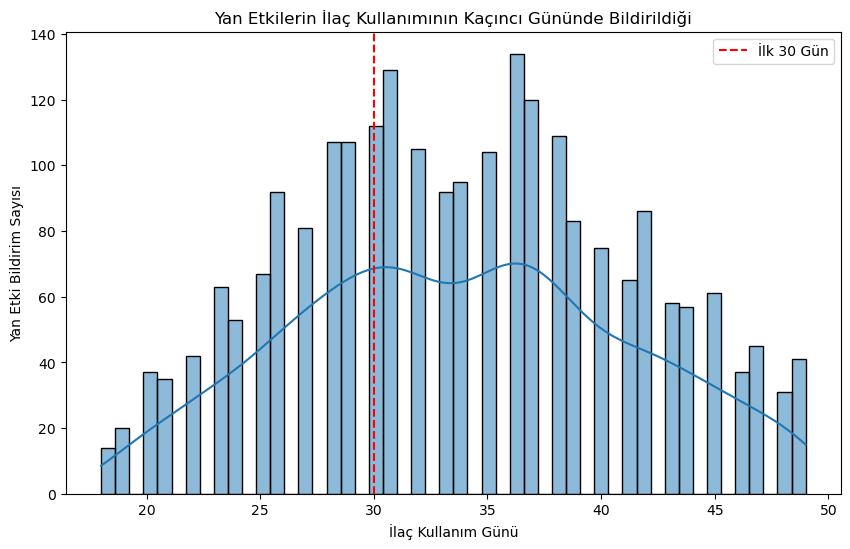

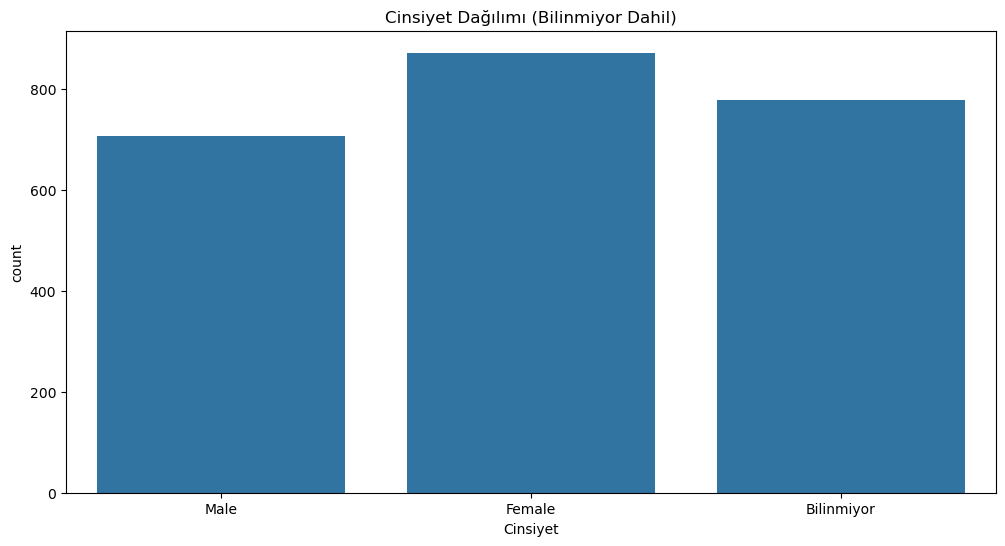

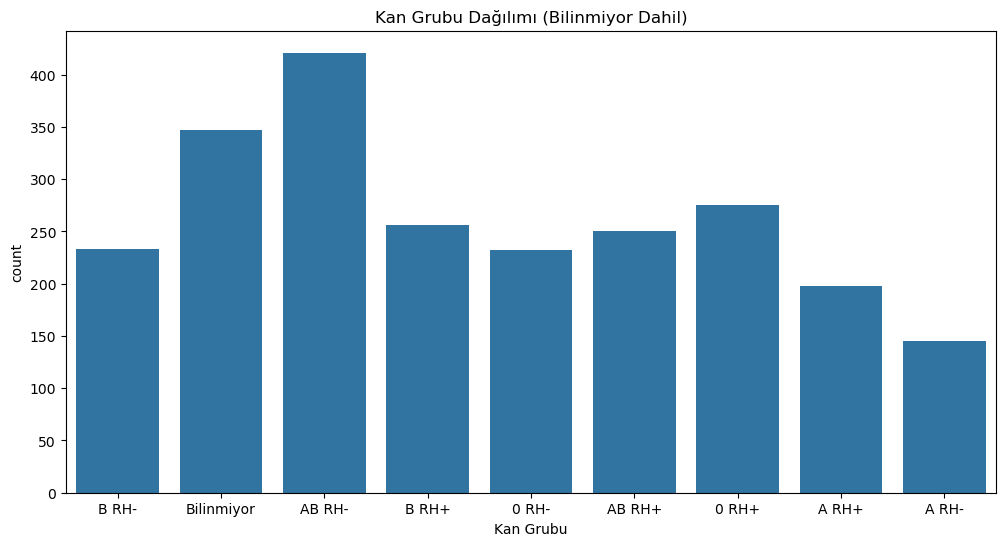

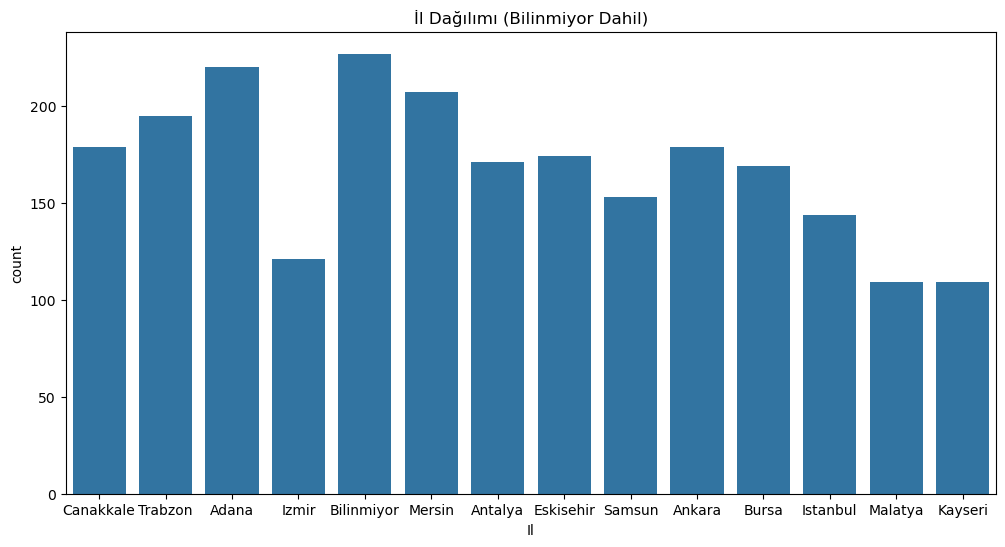

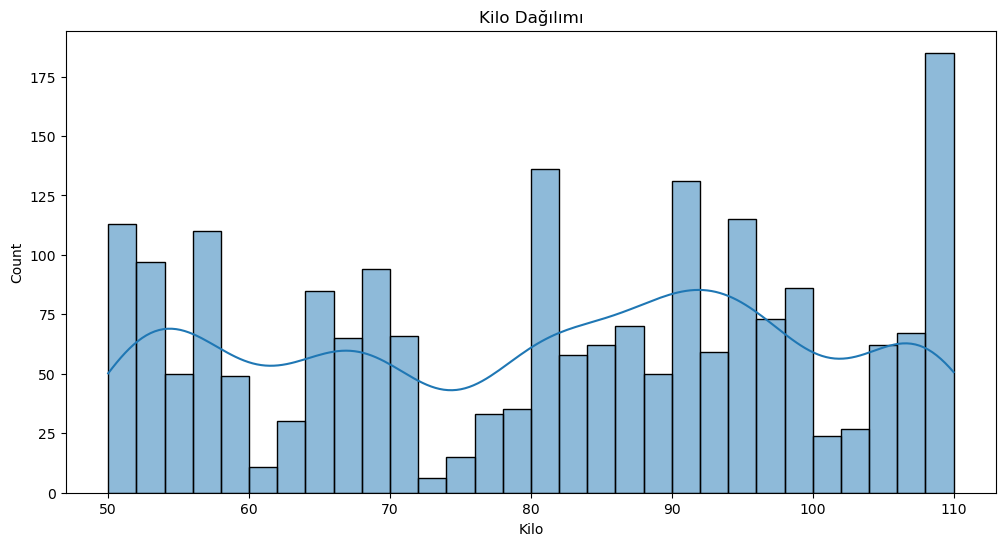

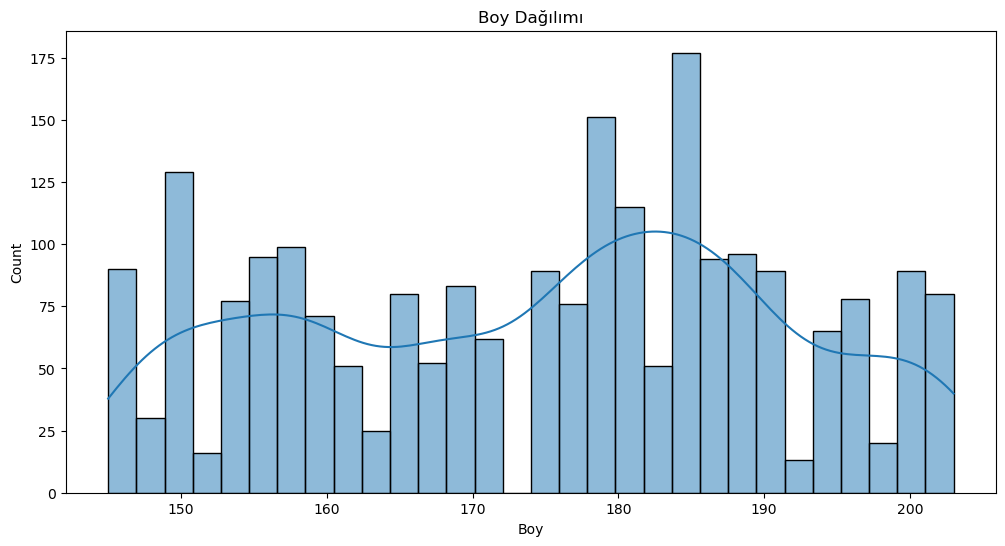

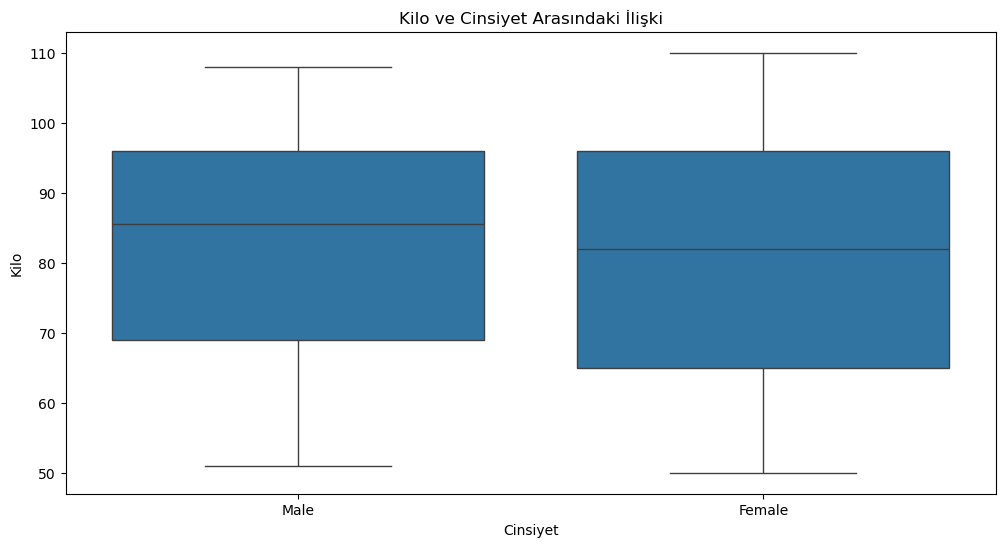

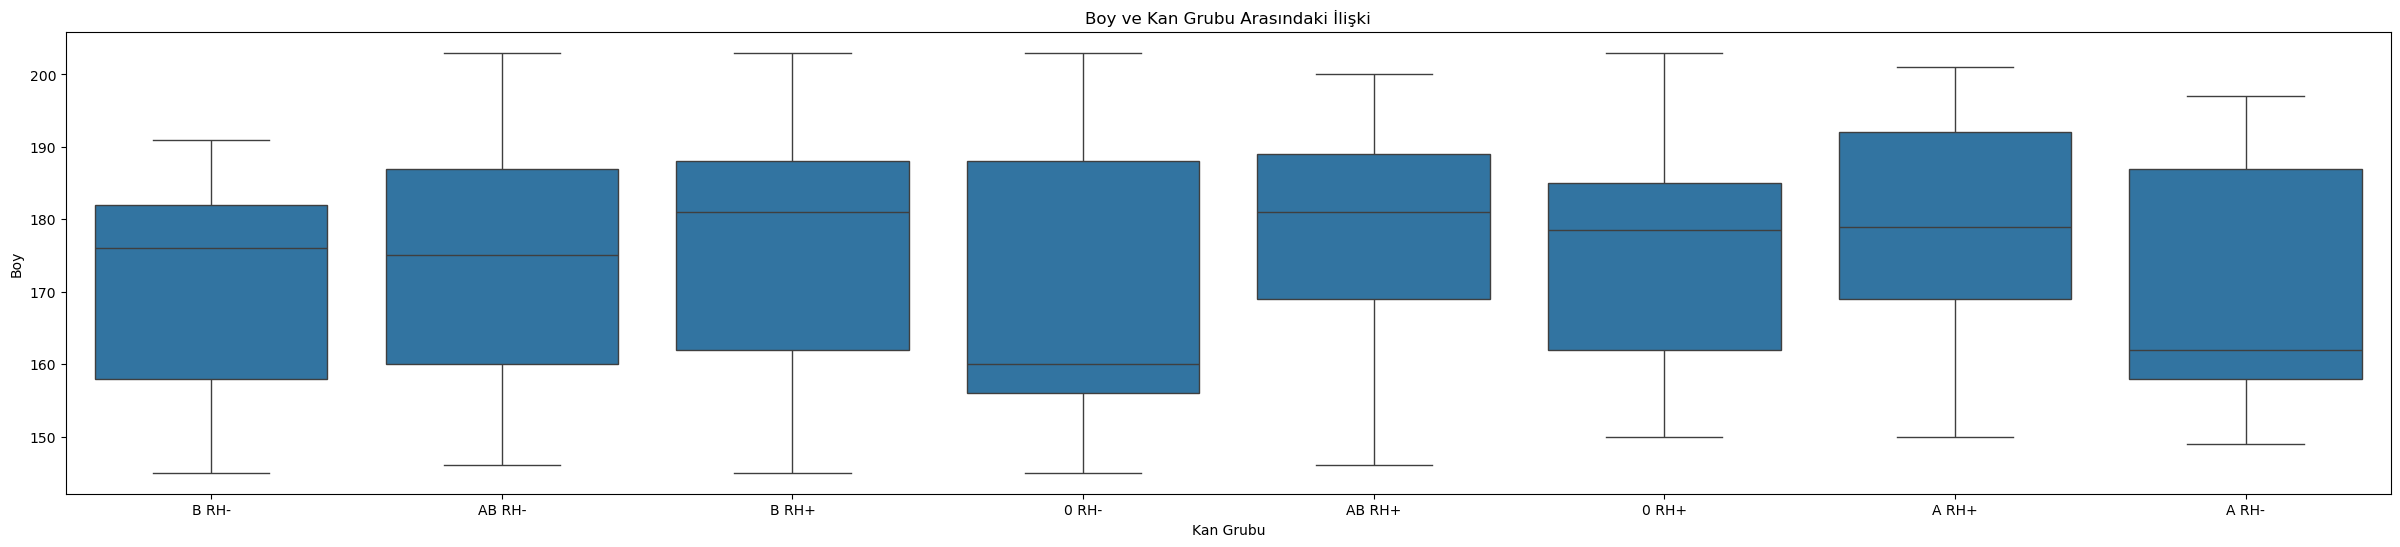

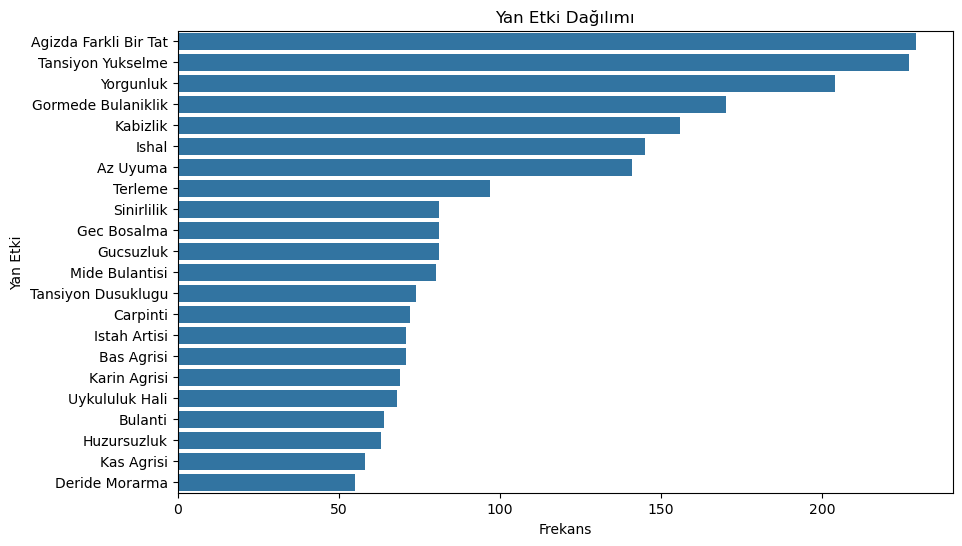

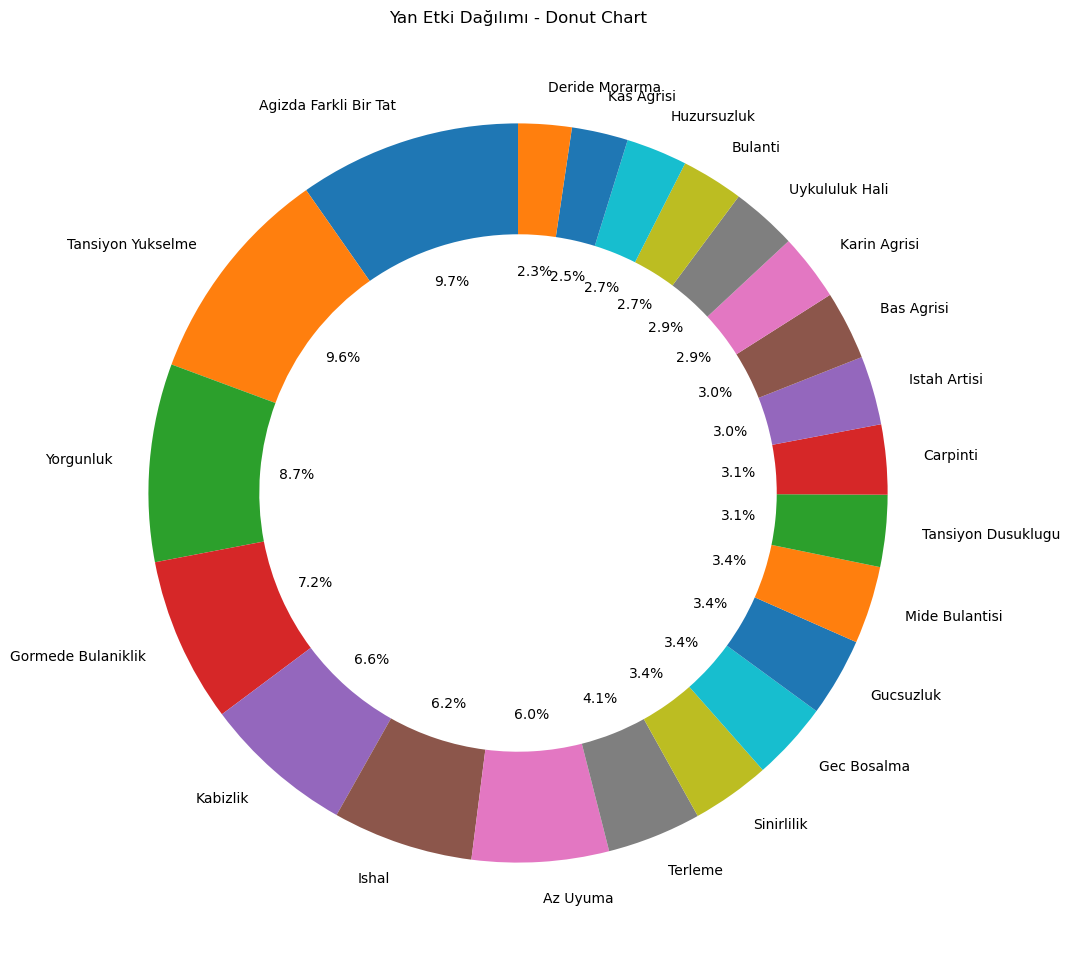

C:\TEMP\ipykernel_17488\3004661384.py:364: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbn.violinplot(x='Yan_Etki', y='Yan_Etki_Ilac_Kullanim_Tarihi', data=X, palette="Set3")


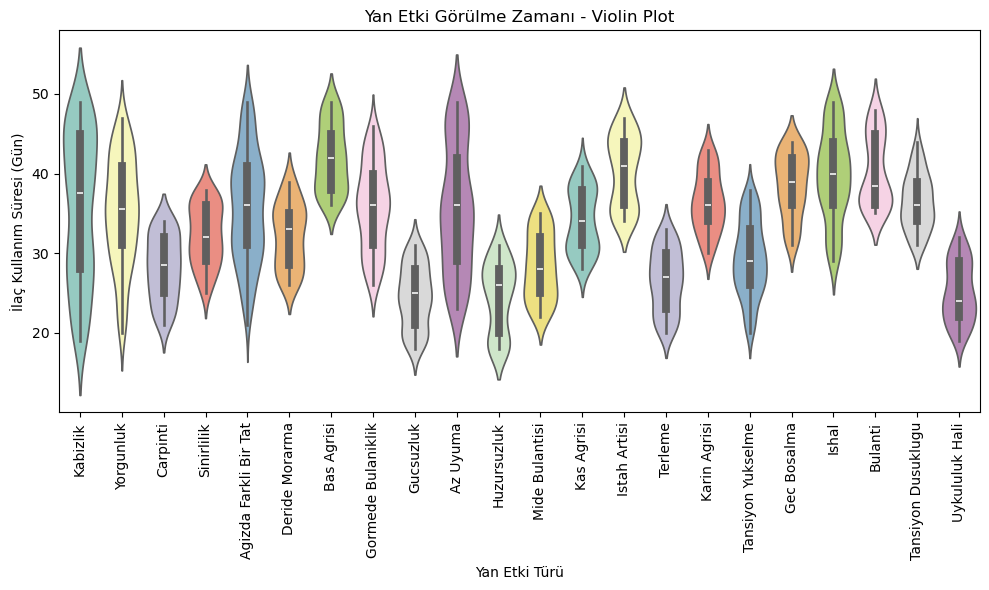

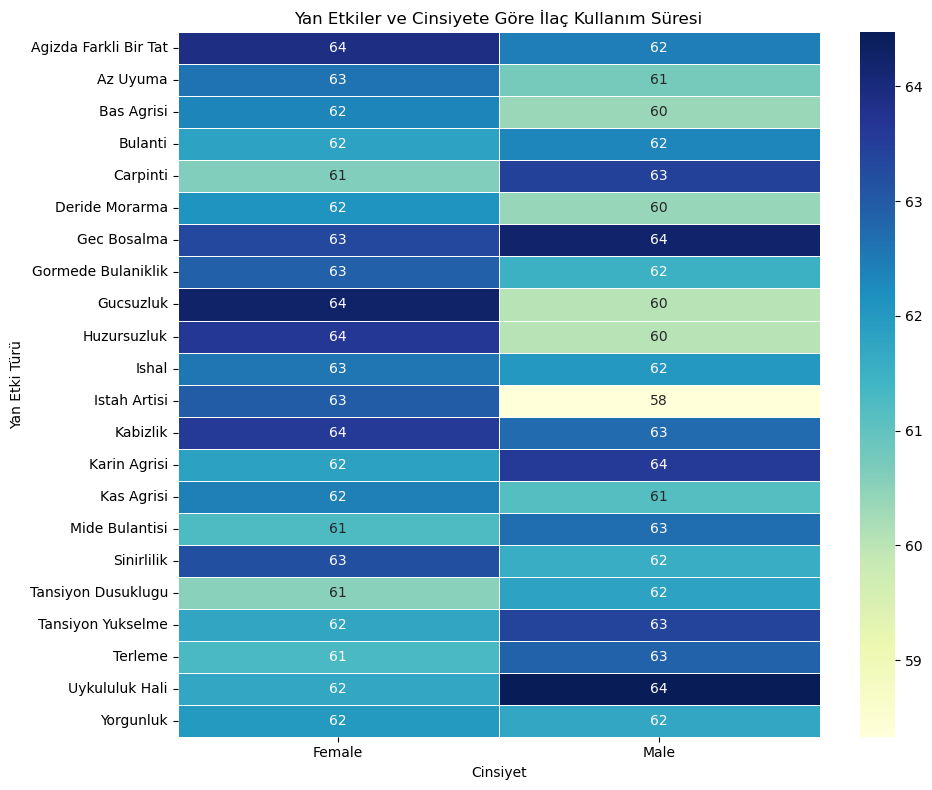

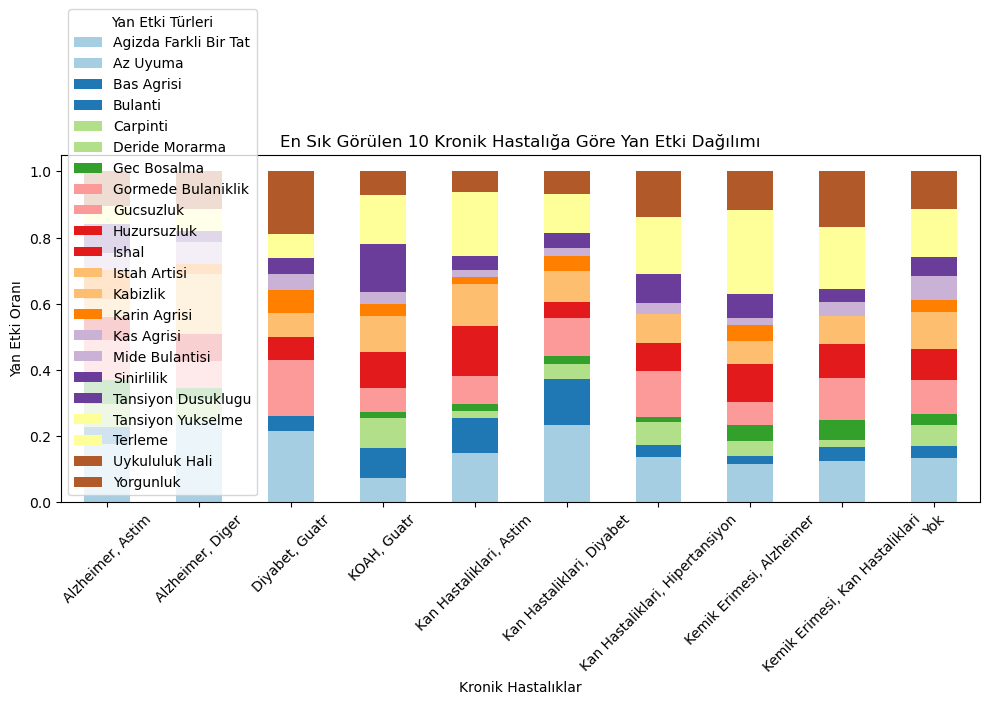

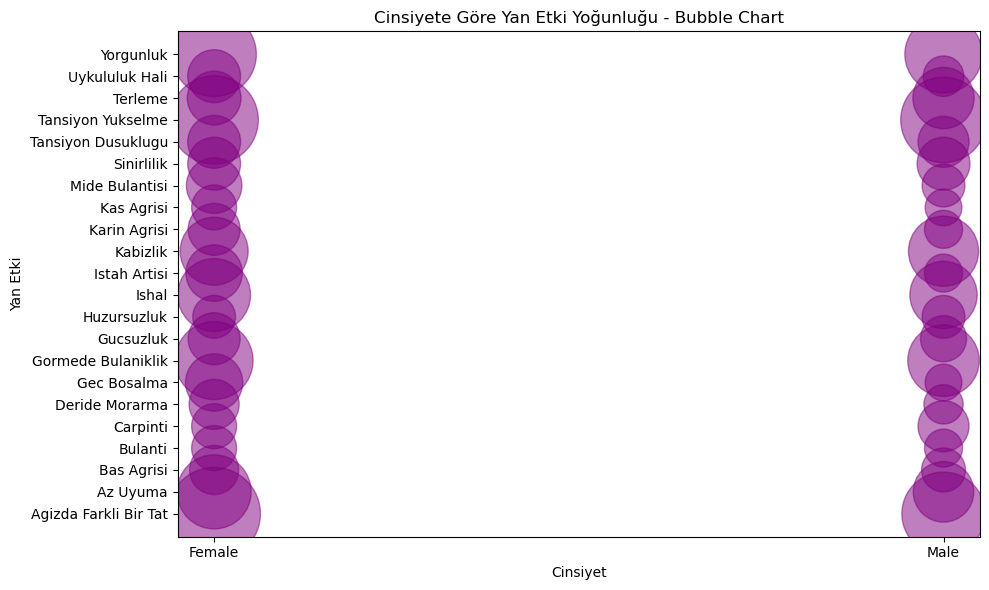

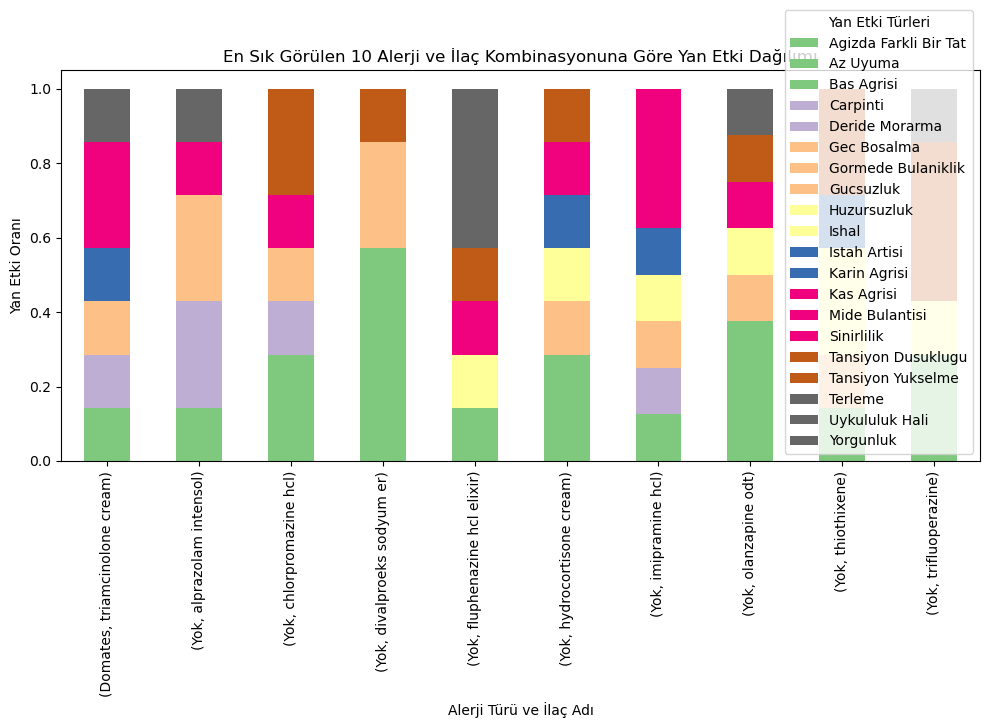

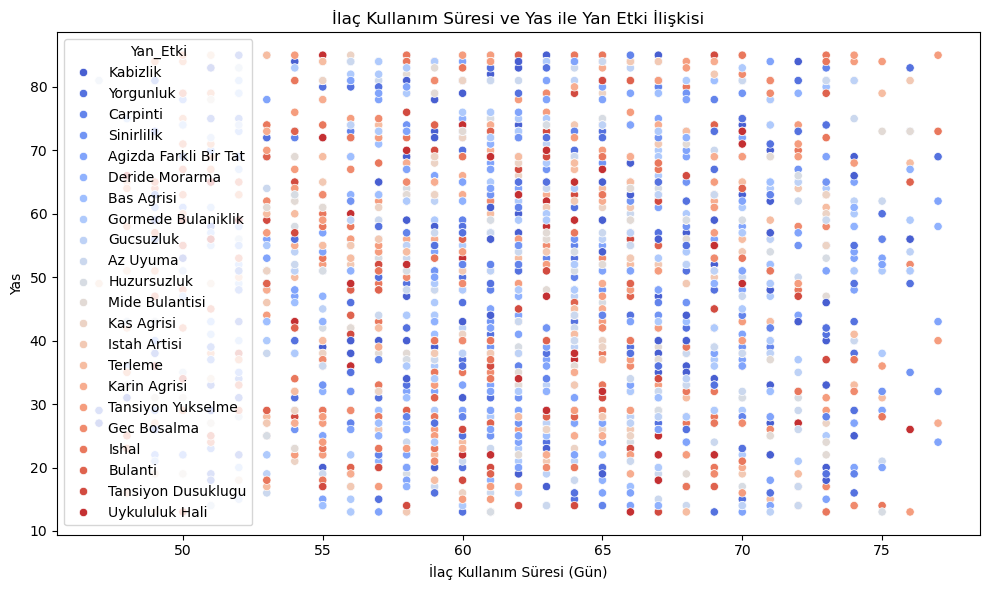

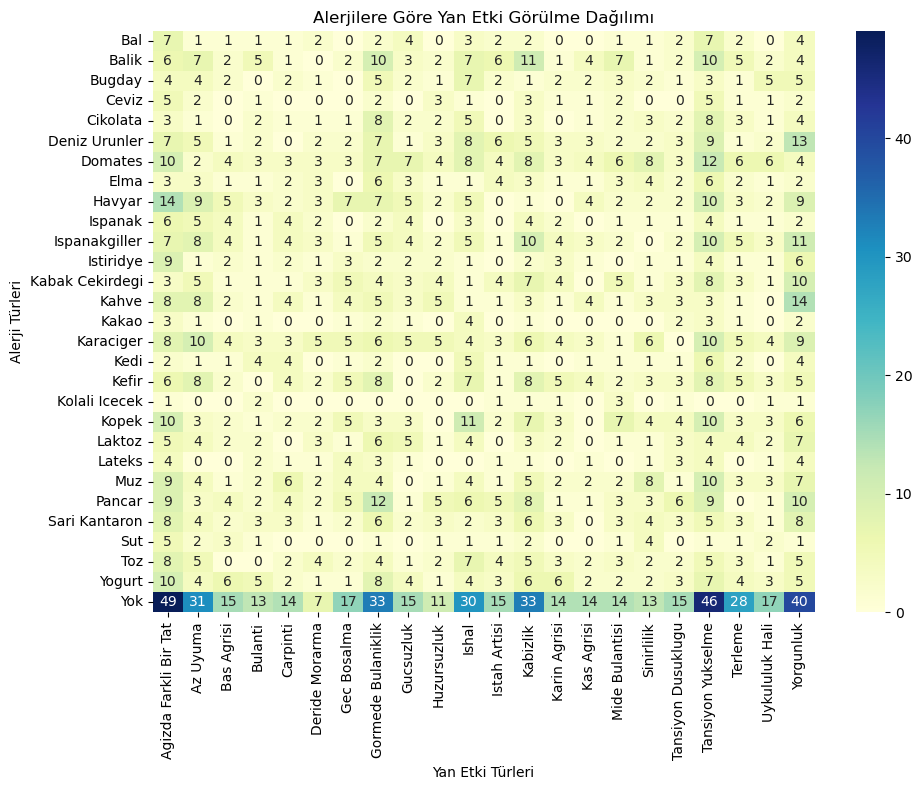

<Figure size 1000x600 with 0 Axes>

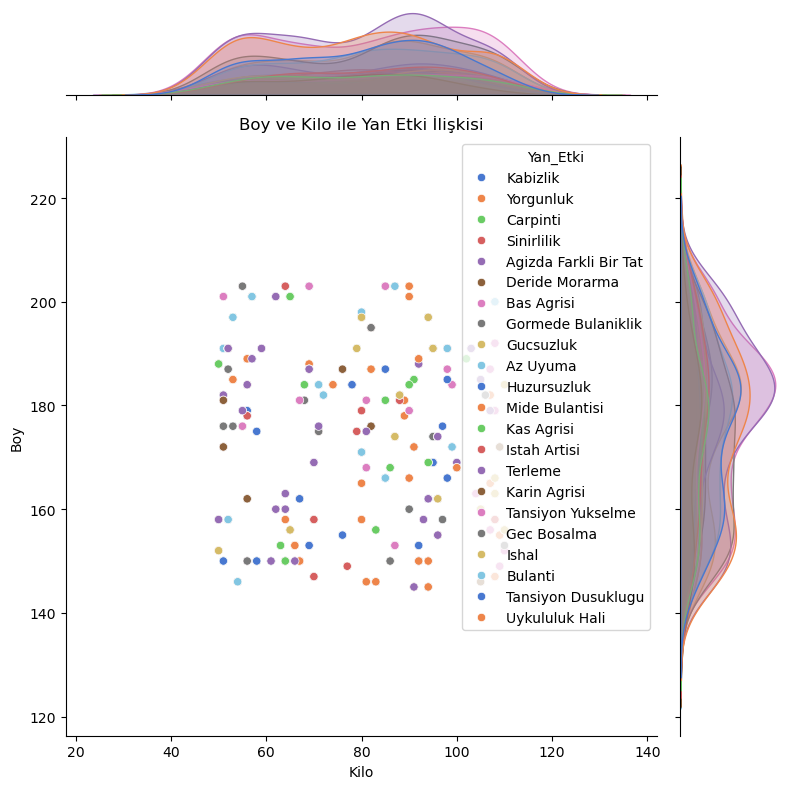

   Kullanici_id Cinsiyet Dogum_Tarihi         Il  \
0           107     Male   1960-03-01  Canakkale   
1           140     Male   1939-10-12    Trabzon   
2             2   Female   1976-12-17  Canakkale   
3            83     Male   1977-06-17      Adana   
4             7   Female   1976-09-03      Izmir   

                         Ilac_Adi Ilac_Baslangic_Tarihi Ilac_Bitis_Tarihi  \
0                 trifluoperazine            2022-01-09        2022-03-04   
1                fluphenazine hcl            2022-01-09        2022-03-08   
2                 warfarin sodium            2022-01-11        2022-03-12   
3                   valproic acid            2022-01-04        2022-03-12   
4  carbamazepine extended release            2022-01-13        2022-03-06   

                Yan_Etki Yan_Etki_Bildirim_Tarihi Alerjilerim  ...  \
0               Kabizlik      2022-02-19 18:28:43       Ceviz  ...   
1              Yorgunluk      2022-02-03 20:48:17         Toz  ...   
2             

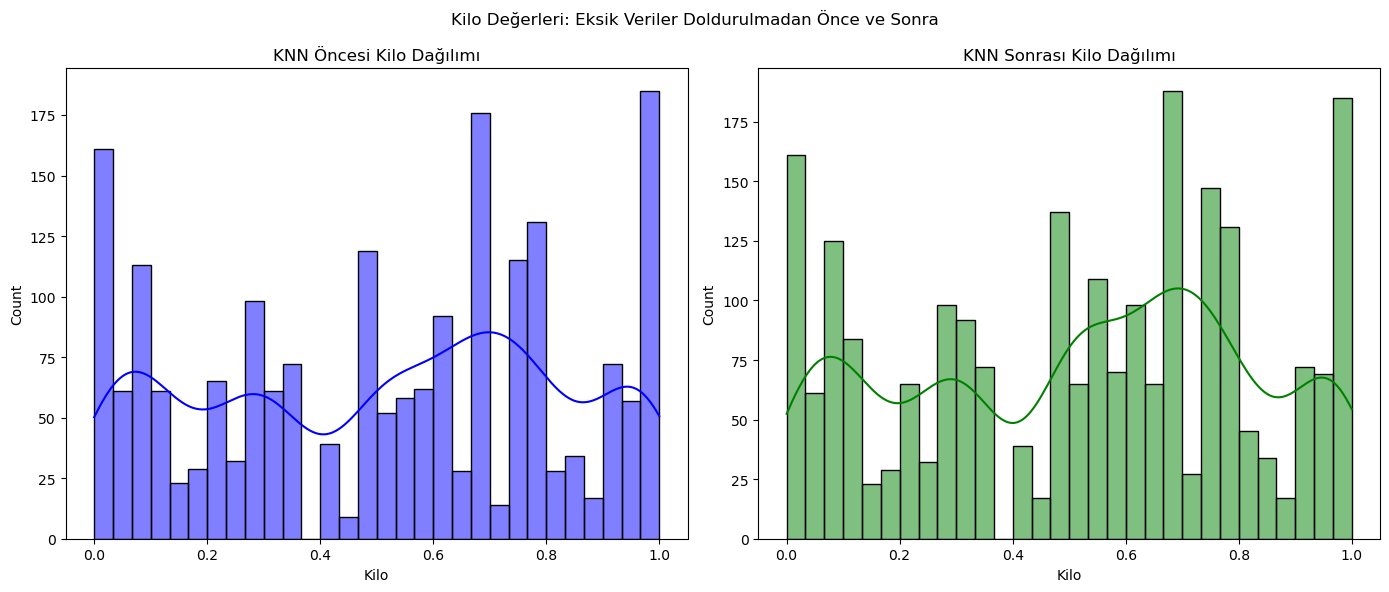

    Kullanici_id Cinsiyet Dogum_Tarihi         Il  \
0            107     Male   1960-03-01  Canakkale   
1            140     Male   1939-10-12    Trabzon   
2              2   Female   1976-12-17  Canakkale   
3             83     Male   1977-06-17      Adana   
4              7   Female   1976-09-03      Izmir   
5            131     Male   1982-01-05        NaN   
6             61      NaN   1997-01-10     Mersin   
7             95      NaN   1997-01-15    Antalya   
8              3   Female   1973-08-05        NaN   
9             53      NaN   1941-10-16      Adana   
10            81      NaN   1955-10-07  Canakkale   
11           108      NaN   1992-03-24  Eskisehir   
12           121     Male   2001-06-01     Samsun   
13            33   Female   1964-05-22      Adana   
14           194     Male   1981-03-01    Antalya   
15            42     Male   1973-09-09     Ankara   
16           182   Female   2002-04-15        NaN   
17           189      NaN   1969-07-23      Bu

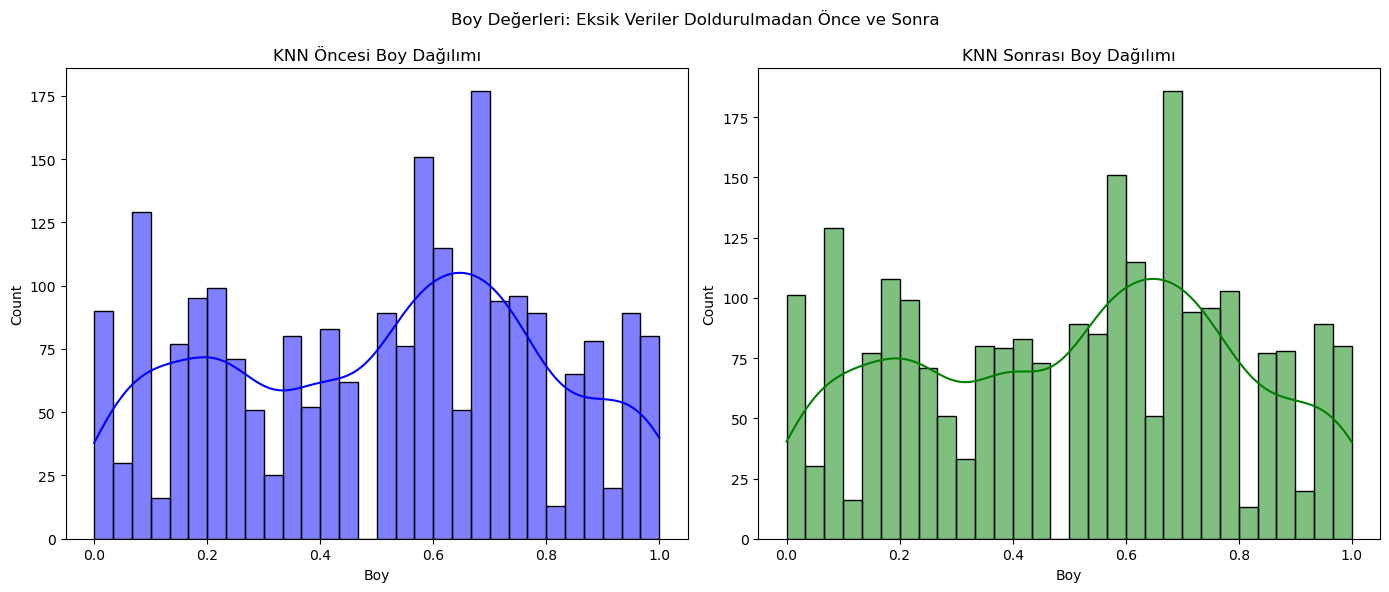

    Kullanici_id Cinsiyet Dogum_Tarihi         Il  \
0            107     Male   1960-03-01  Canakkale   
1            140     Male   1939-10-12    Trabzon   
2              2   Female   1976-12-17  Canakkale   
3             83     Male   1977-06-17      Adana   
4              7   Female   1976-09-03      Izmir   
5            131     Male   1982-01-05        NaN   
6             61      NaN   1997-01-10     Mersin   
7             95      NaN   1997-01-15    Antalya   
8              3   Female   1973-08-05        NaN   
9             53      NaN   1941-10-16      Adana   
10            81      NaN   1955-10-07  Canakkale   
11           108      NaN   1992-03-24  Eskisehir   
12           121     Male   2001-06-01     Samsun   
13            33   Female   1964-05-22      Adana   
14           194     Male   1981-03-01    Antalya   
15            42     Male   1973-09-09     Ankara   
16           182   Female   2002-04-15        NaN   
17           189      NaN   1969-07-23      Bu

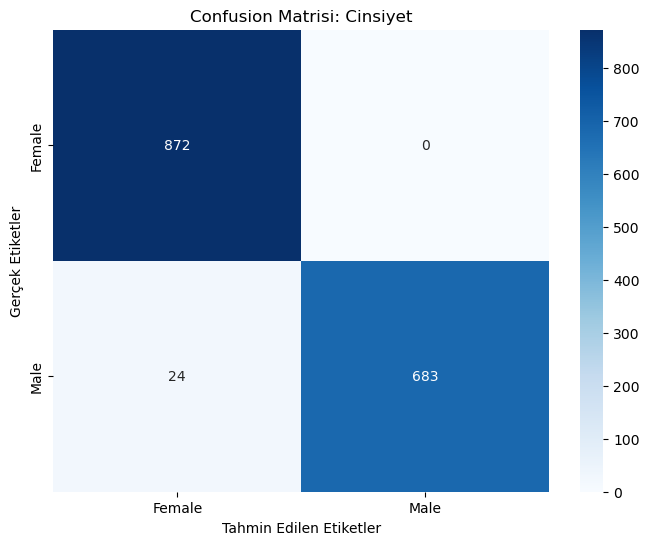

Cinsiyet için sınıflandırma raporu:

              precision    recall  f1-score   support

      Female       0.97      1.00      0.99       872
        Male       1.00      0.97      0.98       707

    accuracy                           0.98      1579
   macro avg       0.99      0.98      0.98      1579
weighted avg       0.99      0.98      0.98      1579



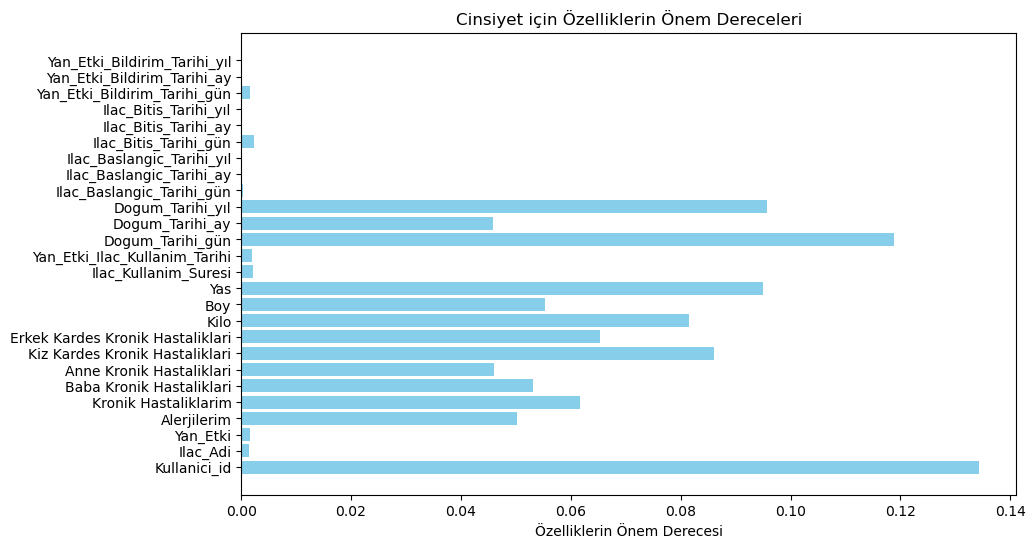

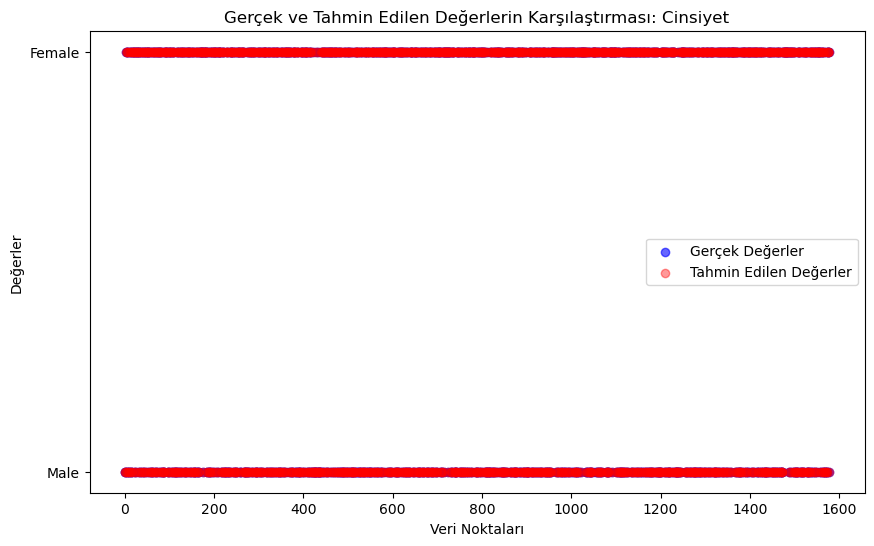

Il için çapraz doğrulama sonuçları: [0.91314554 0.91079812 0.89201878 0.92488263 0.91784038]
Il için ortalama doğruluk: 0.9117


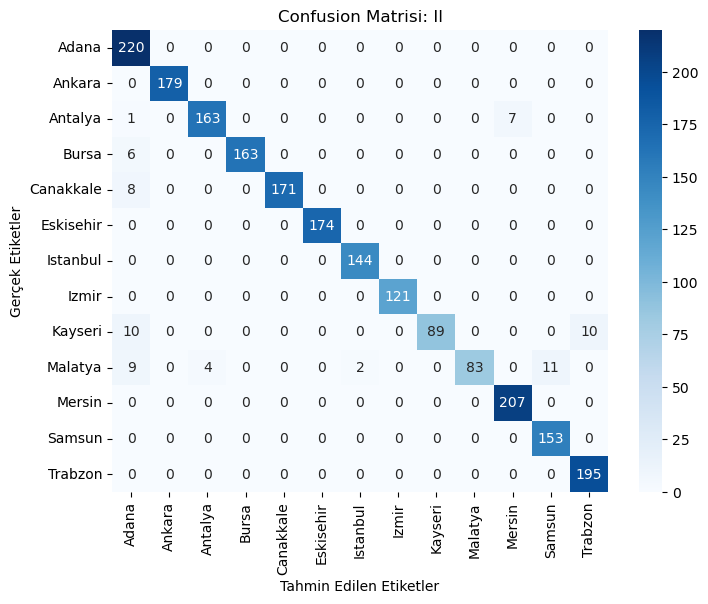

Il için sınıflandırma raporu:

              precision    recall  f1-score   support

       Adana       0.87      1.00      0.93       220
      Ankara       1.00      1.00      1.00       179
     Antalya       0.98      0.95      0.96       171
       Bursa       1.00      0.96      0.98       169
   Canakkale       1.00      0.96      0.98       179
   Eskisehir       1.00      1.00      1.00       174
    Istanbul       0.99      1.00      0.99       144
       Izmir       1.00      1.00      1.00       121
     Kayseri       1.00      0.82      0.90       109
     Malatya       1.00      0.76      0.86       109
      Mersin       0.97      1.00      0.98       207
      Samsun       0.93      1.00      0.97       153
     Trabzon       0.95      1.00      0.97       195

    accuracy                           0.97      2130
   macro avg       0.98      0.96      0.96      2130
weighted avg       0.97      0.97      0.97      2130



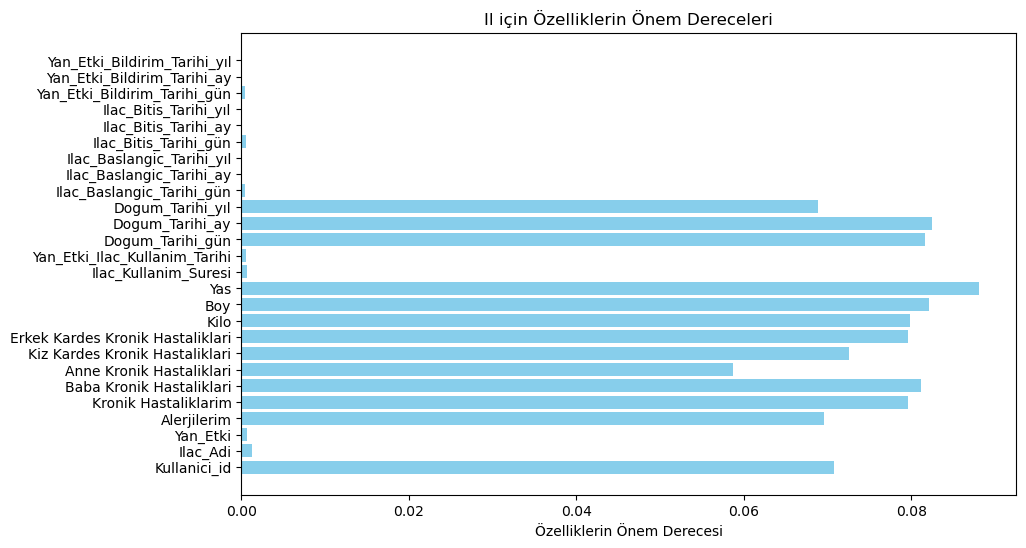

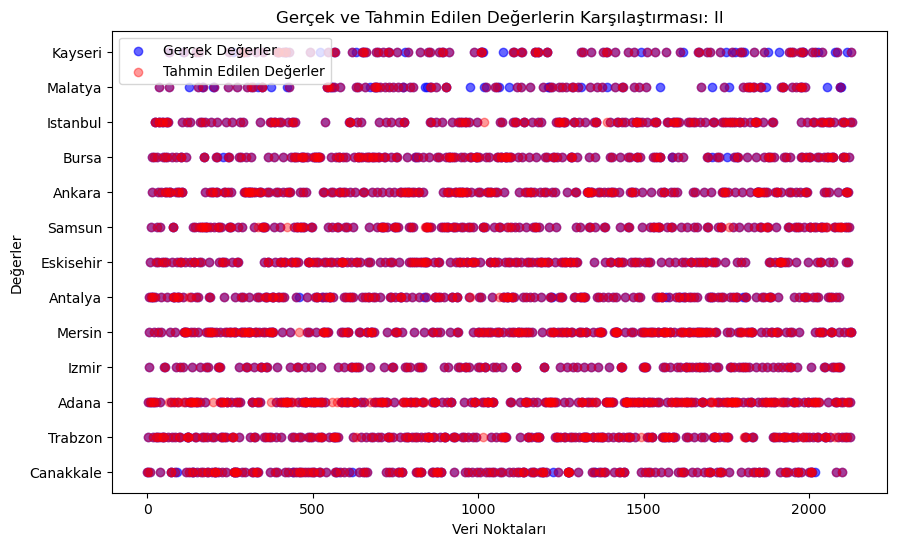

Kan Grubu için çapraz doğrulama sonuçları: [0.84825871 0.85323383 0.83084577 0.83830846 0.8358209 ]
Kan Grubu için ortalama doğruluk: 0.8413


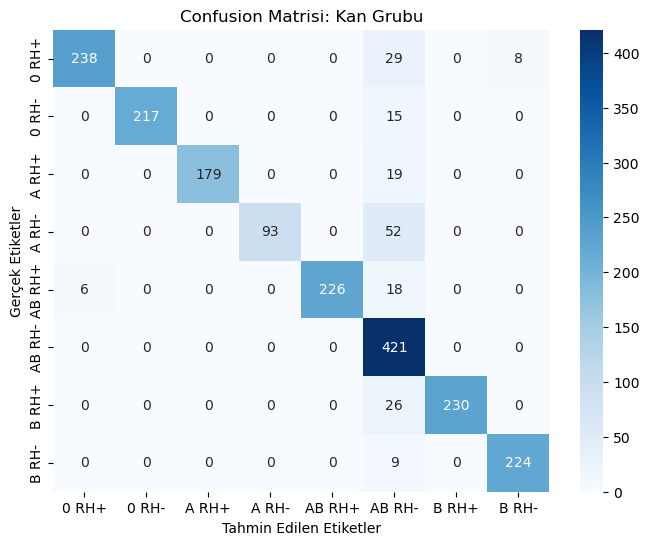

Kan Grubu için sınıflandırma raporu:

              precision    recall  f1-score   support

       0 RH+       0.98      0.87      0.92       275
       0 RH-       1.00      0.94      0.97       232
       A RH+       1.00      0.90      0.95       198
       A RH-       1.00      0.64      0.78       145
      AB RH+       1.00      0.90      0.95       250
      AB RH-       0.71      1.00      0.83       421
       B RH+       1.00      0.90      0.95       256
       B RH-       0.97      0.96      0.96       233

    accuracy                           0.91      2010
   macro avg       0.96      0.89      0.91      2010
weighted avg       0.93      0.91      0.91      2010



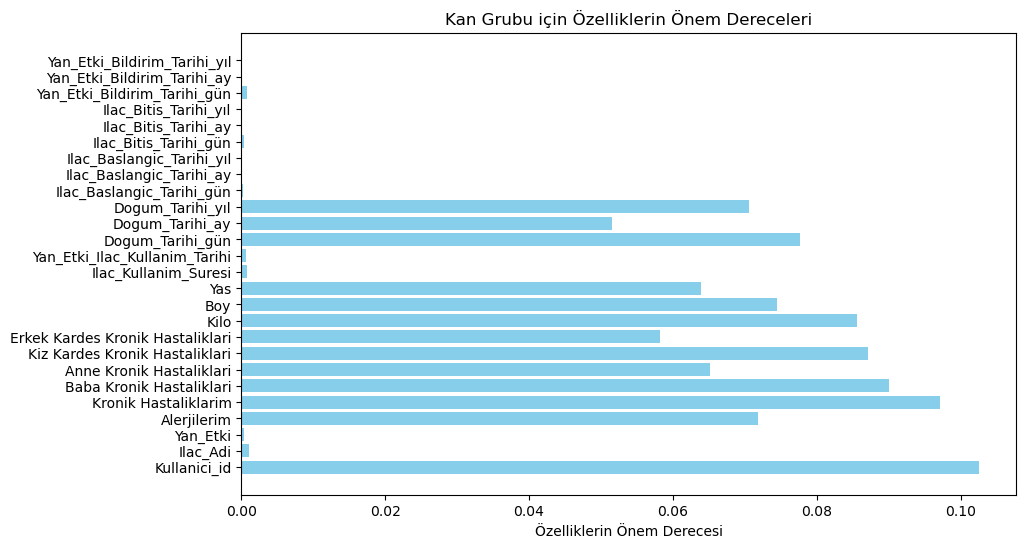

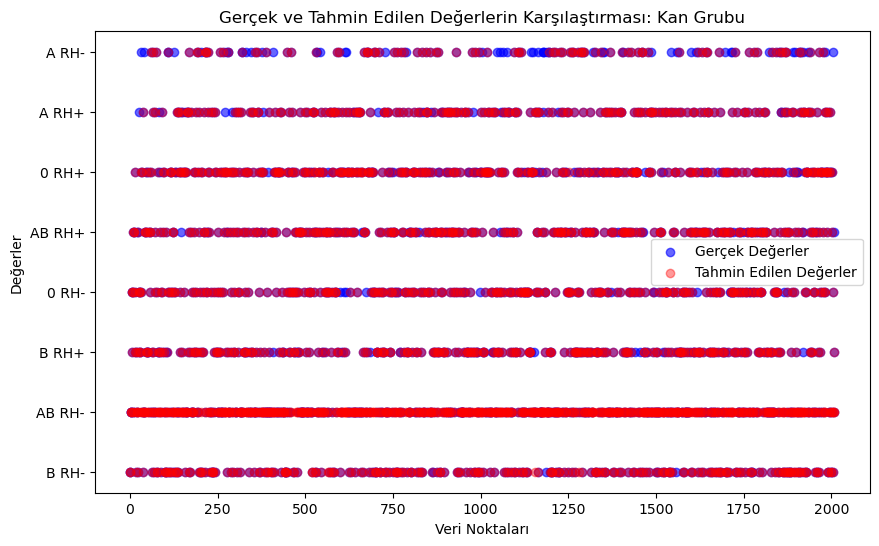

Dogum_Tarihi tarih formatına döndürüldü.
Ilac_Baslangic_Tarihi tarih formatına döndürüldü.
Ilac_Bitis_Tarihi tarih formatına döndürüldü.
Yan_Etki_Bildirim_Tarihi tarih formatına döndürüldü.


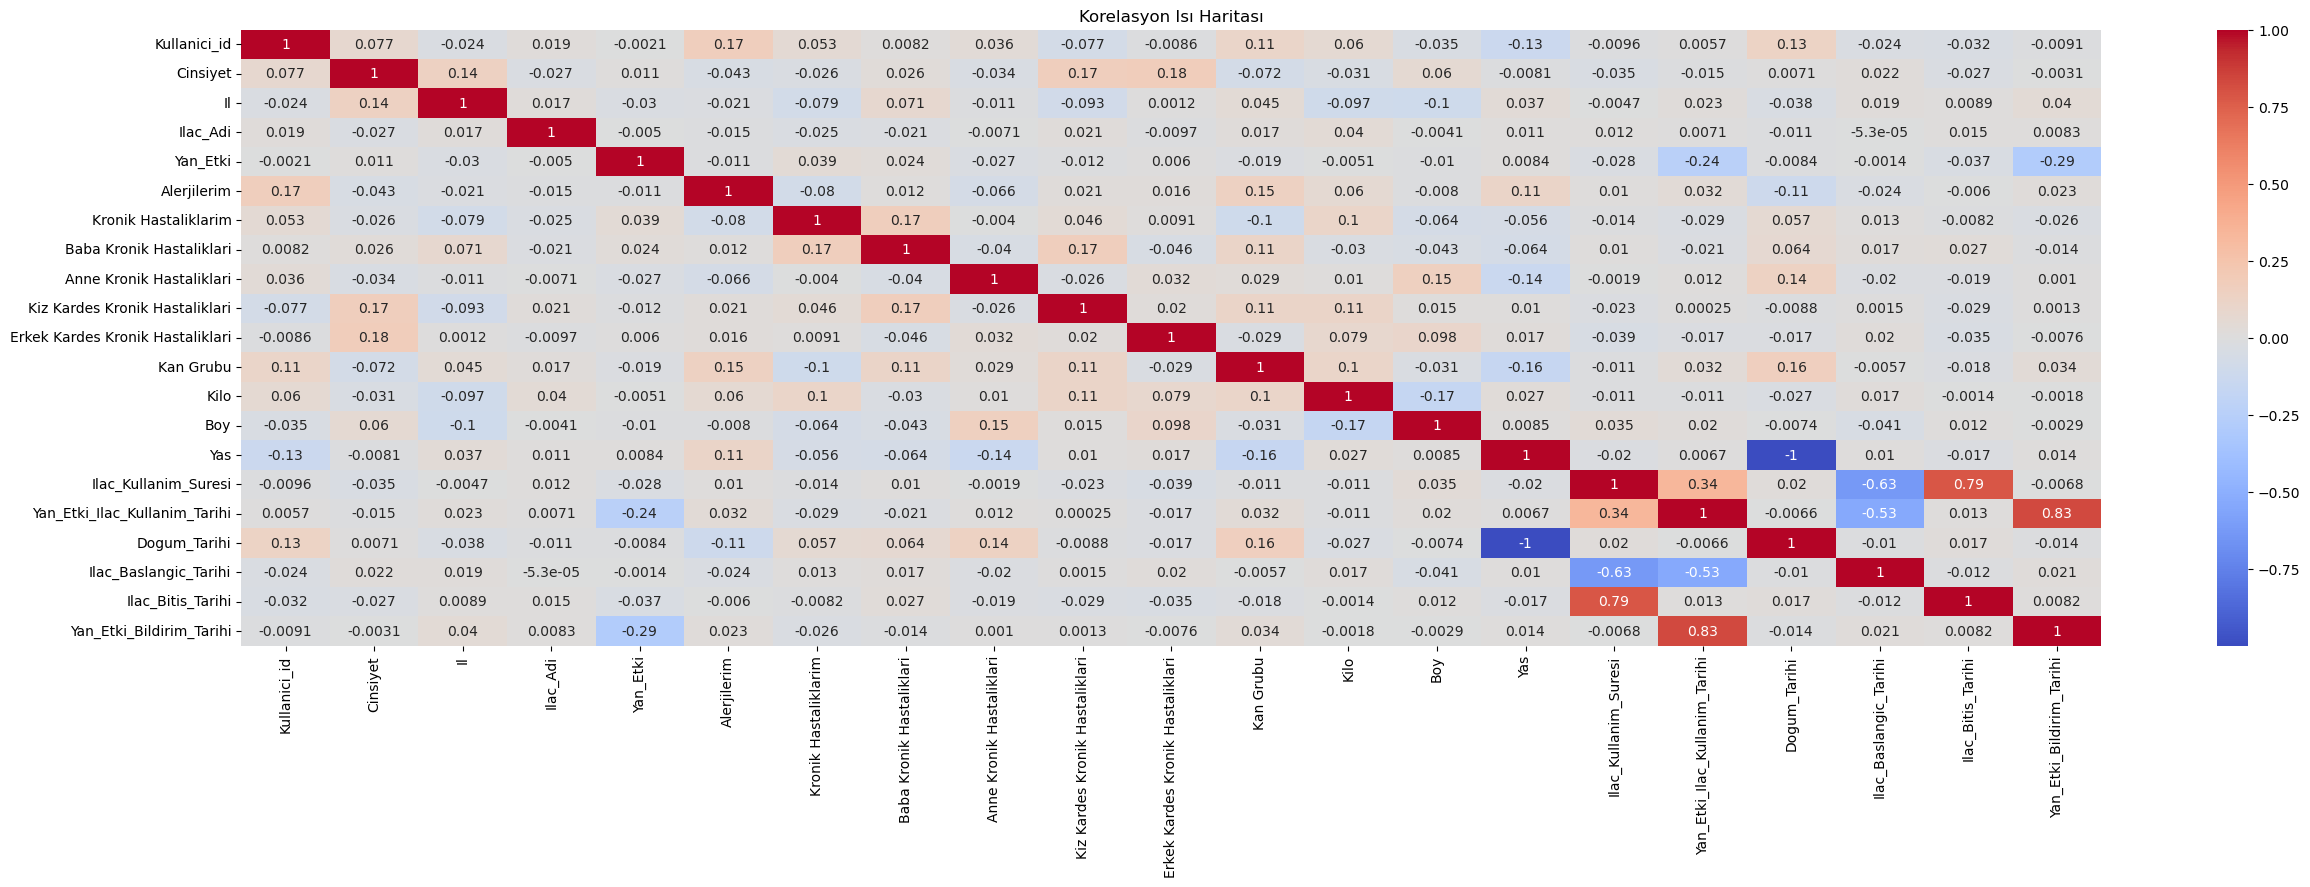

Dogum_Tarihi bileşenlerine ayrıldı.
Ilac_Baslangic_Tarihi bileşenlerine ayrıldı.
Ilac_Bitis_Tarihi bileşenlerine ayrıldı.
Yan_Etki_Bildirim_Tarihi bileşenlerine ayrıldı.


In [5]:
# Dosya yolunu belirt
dosya_yolu = 'side_effect_data 1.xlsx'  # Excel dosyasının yolu

# Veriyi oku
veri = pd.read_excel(dosya_yolu)

# Pipeline'ı uygula
temizlenmis_data = pipeline.fit_transform(veri)